# PRML 3.3.1 : Sequential Bayesian Learning

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from __future__ import unicode_literals, print_function
import six
import sys
import os
import math
import scipy.stats
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('seaborn-whitegrid')

In [2]:
sys.version

'3.6.0 |Anaconda 4.3.0 (x86_64)| (default, Dec 23 2016, 13:19:00) \n[GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.57)]'

## hyper parameters

In [3]:
STD = 0.2
ALPHA = 2.0
BETA = (1/STD)**2 # 精度パラメータ (1/σ)^2

## basis function and design matrix

基底関数を $\phi_{j}(x) = x$ 、計画行列を $\Phi = [\phi_{0}(x), \phi_{1}(x)] = [1, x] \space (M=1)$ とする

In [4]:
def basis_function(x):
    return x

def design_matrix(xs):
    return np.asarray([[1, basis_function(x)] for x in xs])

## generate sample dataset

$x_{n}$ を一様分布 $U(x|-1,1)$ より生成

In [5]:
def uniform_sample():
    return 2 * np.random.random_sample() - 1.0

$f(x_{n}, a) = a_{0} + a_{1} x \space (a_{0} = -0.3, a_{1} = 0.5)$ を評価し，
標準偏差0.2のガウスノイズを加えた目標値 $t_{n}$ を観測データとする

In [6]:
def linear_regression(x, a):
    return design_matrix(x).dot(a)[0]

In [7]:
def observe_sample_data(): 
    x = uniform_sample()
    t = linear_regression([x], np.asarray([-0.3, 0.5])) + np.random.normal(0, STD)
    return x, t

In [8]:
observe_sample_data()

(-0.34480417302542277, -0.85293876410499947)

In [9]:
train_dataset = np.asarray([observe_sample_data() for i in range(0, 20)])
xs = train_dataset[:,0]
ts = train_dataset[:,1]
xs, ts

(array([-0.48566964, -0.98549849, -0.31941375, -0.59091755, -0.62500489,
         0.33046126, -0.48025408, -0.18313045,  0.50465059,  0.58918592,
        -0.71503182, -0.31767492, -0.61751319, -0.70682859, -0.75810317,
         0.05386157,  0.0980187 , -0.88815572, -0.53840491,  0.1638906 ]),
 array([-0.64627317, -0.92518448, -0.3940313 , -0.47227408, -0.9247202 ,
        -0.19258608, -0.16907239, -0.46944306, -0.08816784, -0.05287189,
        -0.2935099 , -0.56901068, -0.31900912, -0.36673815, -0.46290443,
        -0.27670276, -0.38094921, -0.40273496, -0.66110363,  0.01898905]))

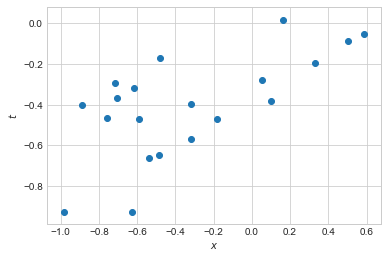

In [10]:
fig, axes = plt.subplots()
axes.scatter(xs, ts)
axes.set_xlabel('$x$')
axes.set_ylabel('$t$')

## gaussian function

- 2変量のガウス関数なら以下の通り
- 多変量のガウス関数なら `scipy.stats.multivariate_normal.pdf()` を使うとよい

In [11]:
def bivariate_gaussian(mean, cov):
    def f(x0, x1):
        z = np.asarray([x0, x1]) - np.asarray(mean)
        det = np.linalg.det(np.asarray(cov))
        return np.exp(-z.dot(np.linalg.inv(np.asarray(cov))).dot(z.T)/2) / \
                (np.sqrt(np.power(2*np.pi, mean.size)) * np.sqrt(det))
    return f

## paramater distribution

In [12]:
w0 = np.linspace(-1., 1., num=3, endpoint=True)
w1 = np.linspace(-1., 1., num=3, endpoint=True)
   
Pw = []
for i in w0:
    Pw.append([bivariate_gaussian(np.asarray([0,0]), np.identity(2))(i,j) for j in w1])
np.asarray(Pw).T

array([[ 0.05854983,  0.09653235,  0.05854983],
       [ 0.09653235,  0.15915494,  0.09653235],
       [ 0.05854983,  0.09653235,  0.05854983]])

In [13]:
def plot_parameter_distribution(axes, mean, cov):
    w0 = np.linspace(-1., 1., num=50, endpoint=True)
    w1 = np.linspace(-1., 1., num=50, endpoint=True)
    
    Pw = []
    for i in w0:
        Pw.append([bivariate_gaussian(mean, cov)(i,j) for j in w1])
    Pw = np.asarray(Pw).T
    
    W0, W1 = np.meshgrid(w0, w1)
    cs = axes.contour(W0, W1, Pw, cmap=plt.cm.jet)
    axes.clabel(cs)
    axes.scatter(-0.3, 0.5, marker='x')
    axes.set_xlabel('$w_0$')
    axes.set_ylabel('$w_1$')
    return axes

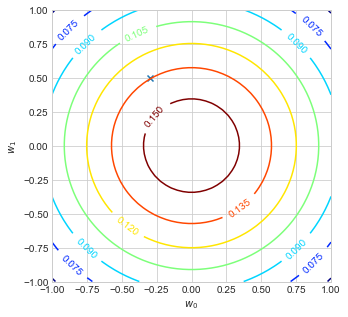

In [14]:
fig, axes = plt.subplots(figsize=(5,5))
plot_parameter_distribution(axes, np.asarray([0,0]), np.identity(2))

## data space

In [15]:
def observe_parameters(mean, cov, num=6):
    return np.asarray([np.random.multivariate_normal(mean, cov) for i in range(0,num)])

In [16]:
ws = observe_parameters(np.asarray([0,0]), np.identity(2)); ws

array([[-0.56080668,  0.38515025],
       [ 0.6692787 , -0.3556969 ],
       [ 0.37780263,  0.05449181],
       [-0.35798019,  0.46224182],
       [-0.69142618, -0.47575369],
       [ 0.82739999,  0.77342806]])

In [17]:
def generate_data_space(w, num=50):
    xs = np.linspace(-1., 1., num=num, endpoint=True)
    ys = np.asarray([linear_regression([x], w) for x in xs])
    return xs, ys

In [18]:
def plot_data_space(axes, mean, cov, xs_observ=[], ts_observ=[]):
    ws = observe_parameters(mean, cov)
    for w in ws:
        xs, ys = generate_data_space(w)
        axes.plot(xs, ys)
    axes.scatter(xs_observ, ts_observ, marker='o')
    axes.set_xlim(-1, 1)
    axes.set_ylim(-1, 1)
    axes.set_xlabel('$x$')
    axes.set_ylabel('$y$')
    return axes

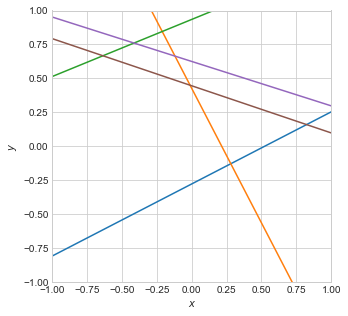

In [19]:
fig, axes = plt.subplots(figsize=(5,5))
plot_data_space(axes, np.asarray([0,0]), np.identity(2))

## likelihood function

(3.11)および(3.12)より $\ln p(t|w) = \frac{N}{2}\ln\beta - \frac{N}{2}\ln(2\pi) - \frac{\beta}{2} \Sigma_{n=1}^{N} ( t_{n} - w^{T} \Phi(x_{n}) )^{2}$

In [20]:
def likelihood(x, t, alpha=1, beta=1, basis_function=lambda x: np.asarray([1, x])):
    def func(ws):
        phi = design_matrix([x])
        return np.exp((1/2)*np.log(beta)-(1/2)*np.log(2*np.pi)-(beta/2)*np.power(t - phi.dot(ws), 2)[0])
    return func

In [21]:
w0 = np.linspace(-1., 1., num=3, endpoint=True)
w1 = np.linspace(-1., 1., num=3, endpoint=True)

Lw = []
for i in w0:
    Lw.append([likelihood(1.0, 0.2, alpha=ALPHA, beta=BETA)(np.asarray([i,j])) for j in w1])
np.asarray(Lw).T

array([[  1.05940963e-26,   3.03794142e-08,   1.20985362e+00],
       [  3.03794142e-08,   1.20985362e+00,   6.69151129e-04],
       [  1.20985362e+00,   6.69151129e-04,   5.13988679e-18]])

In [22]:
def plot_likelihood(axes, x, t, alpha=1, beta=1):
    w0 = np.linspace(-1., 1., num=100, endpoint=True)
    w1 = np.linspace(-1., 1., num=100, endpoint=True)

    Lw = []
    for i in w0:
        Lw.append([likelihood(x, t, alpha, beta)(np.asarray([i,j])) for j in w1])
    Lw = np.asarray(Lw).T
    
    W0, W1 = np.meshgrid(w0, w1)
    cs = axes.contour(W0, W1, Lw, cmap=plt.cm.jet)
    axes.clabel(cs)
    axes.scatter(-0.3, 0.5, marker='x')
    axes.set_xlabel('$w_0$')
    axes.set_ylabel('$w_1$') 

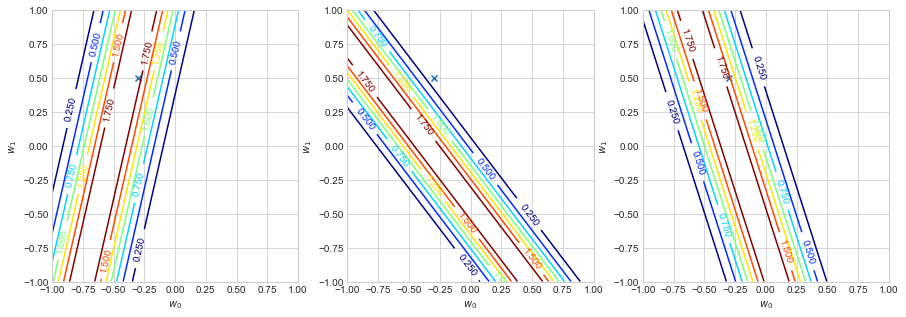

In [23]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5))

for ax in axes:
    x, t = observe_sample_data()
    plot_likelihood(ax, x, t, alpha=ALPHA, beta=BETA)

## covariance and mean

- (3.54) convariance : $S_{N} = (\alpha I + \beta \Phi^{T} \Phi)^{-1}$
- (3.53) mean : $m_{N} = \beta S_{N} \Phi^{T} t$

In [24]:
def covariance(xs, alpha=1, beta=1):
    phis = design_matrix(xs)
    return np.linalg.inv(alpha * np.identity(phis.shape[-1]) + beta * phis.T.dot(phis))

In [25]:
def mean(xs, ts, alpha=1, beta=1):
    cov = covariance(xs, alpha, beta)
    phis = design_matrix(xs)
    ts = np.asarray(ts)
    return beta * cov.dot(phis.T).dot(ts)

In [26]:
covariance(xs, alpha=ALPHA, beta=BETA)

array([[ 0.00298024,  0.00306624],
       [ 0.00306624,  0.009514  ]])

In [27]:
mean(xs, ts, alpha=ALPHA, beta=BETA)

array([-0.28545823,  0.35792095])

## sequential learning process

In [28]:
# 平均と共分散
m = np.asarray([0., 0.])
s = ALPHA * np.identity(m.shape[-1])

# 観測済みのデータ
xs, ts = [], []

### initial state

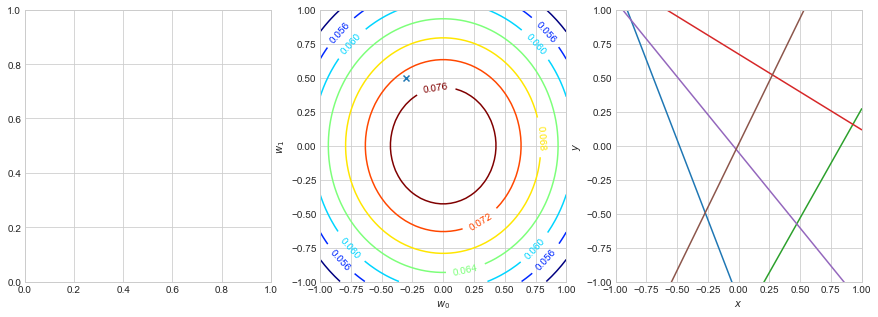

In [29]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
plot_parameter_distribution(axes[1], m, s)
plot_data_space(axes[2], m, s, xs, ts)

### first observation

In [30]:
x, t = observe_sample_data()
xs.append(x)
ts.append(t)
xs, ts

([-0.608917188667992], [-0.26796299587196432])

In [31]:
m = mean(np.asarray(xs), np.asarray(ts), alpha=ALPHA, beta=BETA)
s = covariance(np.asarray(xs), alpha=ALPHA, beta=BETA)
m, s

(array([-0.18470269,  0.11246864]), array([[ 0.15535784,  0.20985853],
        [ 0.20985853,  0.37221353]]))

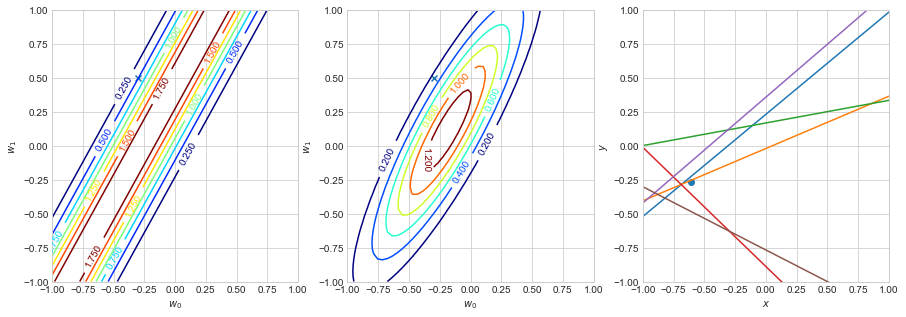

In [32]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
plot_likelihood(axes[0], xs[-1], ts[-1], alpha=ALPHA, beta=BETA)
plot_parameter_distribution(axes[1], m, s)
plot_data_space(axes[2], m, s, xs, ts)

### second observation

In [33]:
x, t = observe_sample_data()
xs.append(x)
ts.append(t)
xs, ts

([-0.608917188667992, 0.4121282763007006],
 [-0.26796299587196432, -0.11499527928441677])

In [34]:
m = mean(np.asarray(xs), np.asarray(ts), alpha=ALPHA, beta=BETA)
s = covariance(np.asarray(xs), alpha=ALPHA, beta=BETA)
m, s

(array([-0.17161389,  0.13212828]), array([[ 0.01982551,  0.00628626],
        [ 0.00628626,  0.0664439 ]]))

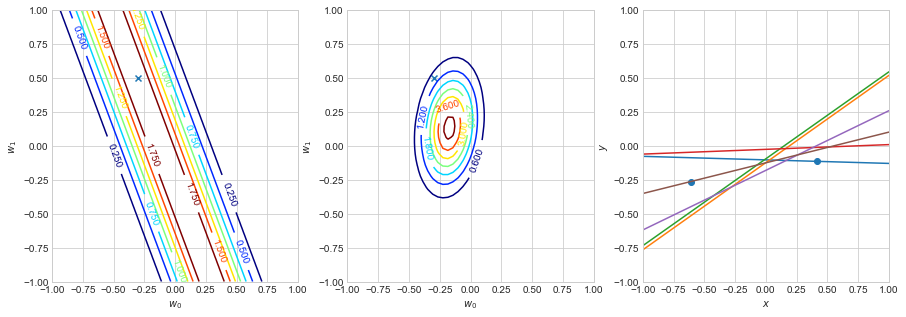

In [35]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
plot_likelihood(axes[0], xs[-1], ts[-1], alpha=ALPHA, beta=BETA)
plot_parameter_distribution(axes[1], m, s)
plot_data_space(axes[2], m, s, xs, ts)

### convergence of a posteriori probability

In [36]:
for i in range(0,18):
    x, t = observe_sample_data()
    xs.append(x)
    ts.append(t)

In [37]:
m = mean(np.asarray(xs), np.asarray(ts), alpha=ALPHA, beta=BETA)
s = covariance(np.asarray(xs), alpha=ALPHA, beta=BETA)
m, s

(array([-0.32958919,  0.47426395]), array([[ 0.00199969, -0.00021299],
        [-0.00021299,  0.0059233 ]]))

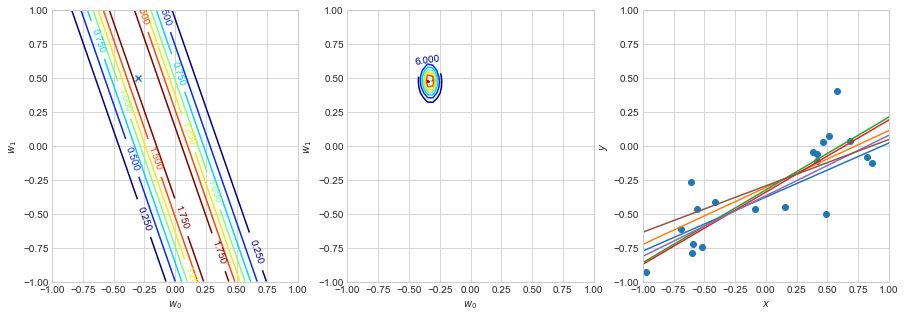

In [38]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
plot_likelihood(axes[0], xs[-1], ts[-1], alpha=ALPHA, beta=BETA)
plot_parameter_distribution(axes[1], m, s)
plot_data_space(axes[2], m, s, xs, ts)